In [1]:
#import libraries and dependencies

from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim

!pip install folium
import folium

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import json
from pandas.io.json import json_normalize

     |████████████████████████████████| 92kB 7.5MB/s eta 0:00:011


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    city_A_data = json.load(json_data)
city_A_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [3]:
neighborhoods_data = city_A_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [4]:
# define the dataframe structure
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.shape

(306, 4)

In [7]:
borough_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
borough_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

In [8]:
borough_data.shape

(40, 4)

In [9]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [10]:
# create map of NYC using latitude and longitude values
map_city_A = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city_A)  
    
map_city_A

In [11]:
# create map of Manhattan using latitude and longitude values
map_borough = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(borough_data['Latitude'], borough_data['Longitude'], borough_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_borough)  
    
map_borough

In [1]:
# The code was removed by Watson Studio for sharing.

Credentials:
Client_ID:
Client_sec:


In [13]:
# get nearby Venues

def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
borough_city_A_venues = getNearbyVenues(names=borough_data['Neighborhood'],
                                   latitudes=borough_data['Latitude'],
                                   longitudes=borough_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [15]:
borough_city_A_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category  
0       40.874412       -73.910271    Pizza Place  
1       40.876844       -73.906204    Yoga Studio  
2       40.880404       -73.908937          Diner  
3       40.877136       -73.906666     Donut Shop  
4       40.877531       -73.905582    Coffee Shop

In [16]:
borough_city_A_venues.shape

(3238, 7)

In [17]:
# get City B data
# parse the HTML file and store info in a df

source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')
table = soup.find(class_='wikitable')

raw_data=[]
for td in table.find_all('td'):
    raw_data.append(td.text.strip())
    
city_B_data = pd.DataFrame(np.array(raw_data).reshape(180,3), columns = ['Postalcode','Borough','Neighborhood'])
city_B_data.head()

Postalcode           Borough                Neighborhood
0        M1A      Not assigned                            
1        M2A      Not assigned                            
2        M3A        North York                   Parkwoods
3        M4A        North York            Victoria Village
4        M5A  Downtown Toronto  Regent Park / Harbourfront

In [18]:
city_B_data=city_B_data[city_B_data['Borough'] != 'Not assigned']

In [19]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [20]:
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
city_B_merged_df = pd.merge(city_B_data, geo_df, on='Postalcode')
city_B_merged_df.head()

Postalcode           Borough                                  Neighborhood  \
0        M3A        North York                                     Parkwoods   
1        M4A        North York                              Victoria Village   
2        M5A  Downtown Toronto                    Regent Park / Harbourfront   
3        M6A        North York             Lawrence Manor / Lawrence Heights   
4        M7A  Downtown Toronto  Queen's Park / Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [21]:
city_B_data=city_B_merged_df
city_B_data.shape

(103, 5)

In [22]:
address= 'Toronto, CA'
geolocator= Nominatim(user_agent='ny explorer')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto are 43.6534817, -79.3839347.


In [23]:

# get a map of the city of Toronto

map_toronto=folium.Map(location=[latitude, longitude], zoomstart=11)

for lat, lng, label in zip(city_B_data['Latitude'], city_B_data['Longitude'], city_B_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        fill=True,
        fill_color='#318cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

In [24]:
# get nearby Venues

def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
city_B_venues = getNearbyVenues(names=city_B_data['Neighborhood'],
                                   latitudes=city_B_data['Latitude'],
                                   longitudes=city_B_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Do

In [26]:
city_B_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2  Victoria Village              43.725882              -79.315572   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1           Variety Store       43.751974       -79.333114   
2  Victoria Village Arena       43.723481       -79.315635   
3             Tim Hortons       43.725517       -79.313103   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1      Food & Drink Shop  
2           Hockey Arena  
3            Coffee Shop  
4  Portuguese Restaurant

In [27]:
city_B_venues.shape

(2173, 7)

In [28]:
merged_venues = pd.merge(borough_city_A_venues, city_B_venues, how='outer')

In [29]:
merged_venues.shape

(5411, 7)

In [30]:
merged_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category  
0       40.874412       -73.910271    Pizza Place  
1       40.876844       -73.906204    Yoga Studio  
2       40.880404       -73.908937          Diner  
3       40.877136       -73.906666     Donut Shop  
4       40.877531       -73.905582    Coffee Shop

In [31]:
# show number of unique categories

merged_venues.groupby('Neighborhood').count()
print('There are {} unique categories.'.format(len(merged_venues['Venue Category'].unique())))

There are 384 unique categories.


In [32]:
merged_onehot = pd.get_dummies(merged_venues[['Venue Category']], prefix="", prefix_sep="")
merged_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
merged_onehot.insert(loc=0, column='Neighborhood', value=merged_venues['Neighborhood'] )
merged_onehot.shape

(5411, 384)

In [33]:
# Group by neighbourhood and getting the mean of the frequency occurancy per category

merged_grouped = merged_onehot.groupby('Neighborhood').mean().reset_index()
merged_grouped.head()

Neighborhood  Accessories Store  \
0                                          Agincourt                0.0   
1                            Alderwood / Long Branch                0.0   
2  Bathurst Manor / Wilson Heights / Downsview North                0.0   
3                                  Battery Park City                0.0   
4                                    Bayview Village                0.0   

   Acupuncturist  Adult Boutique  Afghan Restaurant  African Restaurant  \
0            0.0             0.0                0.0                 0.0   
1            0.0             0.0                0.0                 0.0   
2            0.0             0.0                0.0                 0.0   
3            0.0             0.0                0.0                 0.0   
4            0.0             0.0                0.0                 0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  ...  \
0      0.0                 0.0           0.0             0.0  ...   
1      0.0                 0.0           0.0             0.0  ...   
2      0.0                 0.0           0.0             0.0  ...   
3      0.0                 0.0           0.0             0.0  ...   
4      0.0                 0.0           0.0             0.0  ...   

   Vietnamese Restaurant  Volleyball Court  Warehouse Store  Waterfront  \
0                    0.0               0.0              0.0         0.0   
1                    0.0               0.0              0.0         0.0   
2                    0.0               0.0              0.0         0.0   
3                    0.0               0.0              0.0         0.0   
4                    0.0               0.0              0.0         0.0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0         0.0       0.0      0.000          0.0         0.0000          0.0  
1         0.0       0.0      0.000          0.0         0.0000          0.0  
2         0.0       0.0      0.000          0.0         0.0000          0.0  
3         0.0       0.0      0.025          0.0         0.0125          0.0  
4         0.0       0.0      0.000          0.0         0.0000          0.0  

[5 rows x 384 columns]

In [34]:
merged_grouped.shape

(135, 384)

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [75]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = merged_grouped['Neighborhood']

for ind in np.arange(merged_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(merged_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                          Agincourt          Skating Rink   
1                            Alderwood / Long Branch           Pizza Place   
2  Bathurst Manor / Wilson Heights / Downsview North                  Bank   
3                                  Battery Park City                  Park   
4                                    Bayview Village    Chinese Restaurant   

  2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
0        Breakfast Spot                Lounge  Latin American Restaurant   
1                   Pub          Skating Rink             Sandwich Place   
2           Coffee Shop              Pharmacy             Ice Cream Shop   
3           Coffee Shop                 Hotel                        Gym   
4   Japanese Restaurant                  Café                       Bank   

  5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
0           Yoga Studio                   Dive Bar       Doctor's Office   
1    Athletics & Sports                Coffee Shop                   Gym   
2           Bridal Shop  Middle Eastern Restaurant         Shopping Mall   
3         Memorial Site              Shopping Mall         Boat or Ferry   
4           Yoga Studio        Dumpling Restaurant              Dive Bar   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0               Dog Run      Doner Restaurant             Donut Shop  
1          Dance Studio                  Pool               Pharmacy  
2           Supermarket      Sushi Restaurant         Sandwich Place  
3    Italian Restaurant                 Plaza             Playground  
4       Doctor's Office               Dog Run       Doner Restaurant

In [37]:
neighborhoods_venues_sorted.shape

(135, 11)

In [38]:
# set number of clusters
distorsions = []
K = range(1,10)

merged_grouped_clustering = merged_grouped.drop('Neighborhood', 1)

# run k-means clustering
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(merged_grouped_clustering)
    distorsions.append(kmeans.inertia_)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([7, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

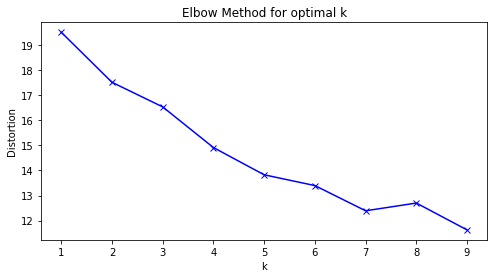

<Figure size 432x288 with 0 Axes>

In [106]:
# Elbow method representation for optimal cluster selection

import matplotlib as mpl
import matplotlib.pyplot as plt


plt.figure(figsize=(8,4))
plt.plot(K, distorsions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()
plt.savefig('Elbow_method.jpeg', transparent=True)

In [111]:
!ls 'Elbow_method.jpeg' 

Elbow_method.jpeg


In [40]:
k=5
kmeans = KMeans(n_clusters=k, random_state=0).fit(merged_grouped_clustering)
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [41]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [42]:
merged_final = merged_venues

In [43]:
merged_final = merged_final.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [44]:
merged_final.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category  Cluster Labels  \
0       40.874412       -73.910271    Pizza Place               1   
1       40.876844       -73.906204    Yoga Studio               1   
2       40.880404       -73.908937          Diner               1   
3       40.877136       -73.906666     Donut Shop               1   
4       40.877531       -73.905582    Coffee Shop               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Sandwich Place           Coffee Shop                   Gym   
1        Sandwich Place           Coffee Shop                   Gym   
2        Sandwich Place           Coffee Shop                   Gym   
3        Sandwich Place           Coffee Shop                   Gym   
4        Sandwich Place           Coffee Shop                   Gym   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Yoga Studio                 Diner            Kids Store   
1           Yoga Studio                 Diner            Kids Store   
2           Yoga Studio                 Diner            Kids Store   
3           Yoga Studio                 Diner            Kids Store   
4           Yoga Studio                 Diner            Kids Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Tennis Stadium      Department Store         Deli / Bodega   
1        Tennis Stadium      Department Store         Deli / Bodega   
2        Tennis Stadium      Department Store         Deli / Bodega   
3        Tennis Stadium      Department Store         Deli / Bodega   
4        Tennis Stadium      Department Store         Deli / Bodega   

  10th Most Common Venue  
0        Supplement Shop  
1        Supplement Shop  
2        Supplement Shop  
3        Supplement Shop  
4        Supplement Shop

In [77]:
merged_final.shape

(5411, 18)

In [45]:
# show map w clusters superimposed

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_final['Neighborhood Latitude'], merged_final['Neighborhood Longitude'], merged_final['Neighborhood'], merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
#Clusters preview
cluster0=merged_final.loc[merged_final['Cluster Labels']==0, merged_final.columns[[0]+list(range(5, merged_final.shape[1]))]]
cluster0.shape

(46, 14)

In [47]:
cluster0.head()

Neighborhood  Venue Longitude       Venue Category  Cluster Labels  \
3238    Parkwoods       -79.332140                 Park               0   
3239    Parkwoods       -79.333114    Food & Drink Shop               0   
3456    Glencairn       -79.443930  Japanese Restaurant               0   
3457    Glencairn       -79.444053     Sushi Restaurant               0   
3458    Glencairn       -79.442378                  Pub               0   

     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
3238     Food & Drink Shop                  Park           Yoga Studio   
3239     Food & Drink Shop                  Park           Yoga Studio   
3456   Japanese Restaurant                   Pub      Sushi Restaurant   
3457   Japanese Restaurant                   Pub      Sushi Restaurant   
3458   Japanese Restaurant                   Pub      Sushi Restaurant   

     4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
3238   Dumpling Restaurant        Discount Store   Distribution Center   
3239   Dumpling Restaurant        Discount Store   Distribution Center   
3456                  Park           Yoga Studio             Drugstore   
3457                  Park           Yoga Studio             Drugstore   
3458                  Park           Yoga Studio             Drugstore   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
3238              Dive Bar       Doctor's Office               Dog Run   
3239              Dive Bar       Doctor's Office               Dog Run   
3456                 Diner        Discount Store   Distribution Center   
3457                 Diner        Discount Store   Distribution Center   
3458                 Diner        Discount Store   Distribution Center   

     10th Most Common Venue  
3238       Doner Restaurant  
3239       Doner Restaurant  
3456               Dive Bar  
3457               Dive Bar  
3458               Dive Bar

In [48]:
cluster1=merged_final.loc[merged_final['Cluster Labels']==1, merged_final.columns[[0]+list(range(5, merged_final.shape[1]))]]
cluster1.shape

(5361, 14)

In [49]:
cluster1.head()

Neighborhood  Venue Longitude Venue Category  Cluster Labels  \
0  Marble Hill       -73.910271    Pizza Place               1   
1  Marble Hill       -73.906204    Yoga Studio               1   
2  Marble Hill       -73.908937          Diner               1   
3  Marble Hill       -73.906666     Donut Shop               1   
4  Marble Hill       -73.905582    Coffee Shop               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Sandwich Place           Coffee Shop                   Gym   
1        Sandwich Place           Coffee Shop                   Gym   
2        Sandwich Place           Coffee Shop                   Gym   
3        Sandwich Place           Coffee Shop                   Gym   
4        Sandwich Place           Coffee Shop                   Gym   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Yoga Studio                 Diner            Kids Store   
1           Yoga Studio                 Diner            Kids Store   
2           Yoga Studio                 Diner            Kids Store   
3           Yoga Studio                 Diner            Kids Store   
4           Yoga Studio                 Diner            Kids Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Tennis Stadium      Department Store         Deli / Bodega   
1        Tennis Stadium      Department Store         Deli / Bodega   
2        Tennis Stadium      Department Store         Deli / Bodega   
3        Tennis Stadium      Department Store         Deli / Bodega   
4        Tennis Stadium      Department Store         Deli / Bodega   

  10th Most Common Venue  
0        Supplement Shop  
1        Supplement Shop  
2        Supplement Shop  
3        Supplement Shop  
4        Supplement Shop

In [50]:
cluster2=merged_final.loc[merged_final['Cluster Labels']==2, merged_final.columns[[0]+list(range(5, merged_final.shape[1]))]]
cluster2.shape

(1, 14)

In [51]:
cluster2.head()

Neighborhood  Venue Longitude  \
3461  Rouge Hill / Port Union / Highland Creek       -79.163085   

     Venue Category  Cluster Labels 1st Most Common Venue  \
3461            Bar               2                   Bar   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
3461           Yoga Studio   Filipino Restaurant        Discount Store   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
3461   Distribution Center              Dive Bar       Doctor's Office   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
3461               Dog Run      Doner Restaurant             Donut Shop

In [52]:
cluster3=merged_final.loc[merged_final['Cluster Labels']==3, merged_final.columns[[0]+list(range(5, merged_final.shape[1]))]]
cluster3.shape

(2, 14)

In [53]:
cluster3.head()

Neighborhood  Venue Longitude  \
4570                                  Humberlea / Emery       -79.532854   
5396  Old Mill South / King's Mill Park / Sunnylea /...       -79.496266   

      Venue Category  Cluster Labels 1st Most Common Venue  \
4570  Baseball Field               3        Baseball Field   
5396  Baseball Field               3        Baseball Field   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4570           Yoga Studio   Filipino Restaurant        Discount Store   
5396           Yoga Studio   Filipino Restaurant        Discount Store   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
4570   Distribution Center              Dive Bar       Doctor's Office   
5396   Distribution Center              Dive Bar       Doctor's Office   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
4570               Dog Run      Doner Restaurant             Donut Shop  
5396               Dog Run      Doner Restaurant             Donut Shop

In [54]:
cluster4=merged_final.loc[merged_final['Cluster Labels']==4, merged_final.columns[[0]+list(range(5, merged_final.shape[1]))]]
cluster4.shape

(1, 14)

In [55]:
cluster4.head()

Neighborhood  Venue Longitude Venue Category  \
4497  Willowdale / Newtonbrook       -79.411798            Gym   

      Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
4497               4                   Gym           Yoga Studio   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
4497    Dim Sum Restaurant        Discount Store   Distribution Center   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
4497              Dive Bar       Doctor's Office               Dog Run   

     9th Most Common Venue 10th Most Common Venue  
4497      Doner Restaurant             Donut Shop

In [125]:
#perform DBSCAN clustering tecnique to confirmm outliers

from sklearn.cluster import DBSCAN
epsilon=0.7
minimumsamples=5
db=DBSCAN(eps=epsilon, min_samples=minimumsamples).fit(merged_grouped_clustering)
labels=db.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0])

In [126]:
n_clusters=len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

1